# Collaborative Filtering using miniai

## Import Libraries

In [ ]:
from miniai.datasets import DataLoaders
from miniai.learner import MetricsCB, DeviceCB, ProgressCB, TrainLearner
from miniai.activations import set_seed
from miniai.sgd import BatchSchedCB, RecorderCB

from torcheval.metrics import MulticlassAccuracy, Mean
from torch.optim import AdamW, lr_scheduler
from torch.utils.data import (
    Dataset, DataLoader, RandomSampler, BatchSampler)
import torch.nn as nn #Embedding, Module, MSELoss

import torch.nn.functional as F

In [ ]:
import urllib.request
import zipfile

import pandas as pd
import numpy as np
import torch

from pathlib import Path
from functools import partial

## MovieLens 100K Dataset

In [ ]:
movielens_100K_url = 'https://files.grouplens.org/datasets/movielens/ml-100k.zip'

filename = Path(movielens_100K_url).name
zip_path = Path('.')
extract_path = zip_path / Path(filename).stem

In [ ]:
zip_path

Path('.')

True

In [ ]:
with urllib.request.urlopen(movielens_100K_url) as response:
    with open(filename, "wb") as f:
      f.write(response.read())
    
with zipfile.ZipFile(filename, "r") as zip_ref:
    zip_ref.extractall(zip_path)

In [ ]:
ratings = pd.read_csv(
    extract_path/'u.data', delimiter='\t', header=None,
    usecols=(0,1,2), names=['user','movie','rating'])

movies = pd.read_csv(
    extract_path/'u.item',  delimiter='|', encoding='latin-1',
    usecols=(0,1), names=('movie','title'), header=None)

ratings = ratings.merge(movies)
ratings

,user,movie,rating,title
0,196,242,3,Kolya (1996)
1,63,242,3,Kolya (1996)
2,226,242,5,Kolya (1996)
3,154,242,3,Kolya (1996)
4,306,242,5,Kolya (1996)
...,...,...,...,...
99995,840,1674,4,Mamma Roma (1962)
99996,655,1640,3,"Eighth Day, The (1996)"
99997,655,1637,3,Girls Town (1996)
99998,655,1630,3,"Silence of the Palace, The (Saimt el Qusur) (1..."


In [ ]:
print(f'Number of users: {len(ratings.user.unique())}')
print(f'Number of movies: {len(ratings.movie.unique())}')
print(f'Number of titles: {len(ratings.title.unique())}')

Number of users: 943
Number of movies: 1682
Number of titles: 1664


## Custom Splitter
Inspired by:  
https://github.com/microsoft/recommenders/blob/main/recommenders/datasets/python_splitters.py
- In "recommenders" library, when spliting by 'item', `python_stratified_split` puts both rows of movies with only two ratings in the training set.
- The version I propose here puts one in the training and one in validation set.

In [ ]:
DEFAULT_USER_COL = 'user'
DEFAULT_ITEM_COL = 'title'

def split_dataframe_by_group(
    data:pd.DataFrame,
    ratio:float=0.75,
    filter_by:str="user", # item or user
    seed:int=42,
    col_user:str=DEFAULT_USER_COL,
    col_item:str=DEFAULT_ITEM_COL,
    sort_column=None
):
    """Return split based on 'user' or 'item' column
    """
    # A few preliminary checks.
    if not (filter_by in ["user", "item"]):
        raise ValueError("filter_by should be either 'user' or 'item'.")
    if col_user not in data.columns:
        raise ValueError("Schema of data not valid. Missing User Col")
    if col_item not in data.columns:
        raise ValueError("Schema of data not valid. Missing Item Col")

    split_by_column = col_user if filter_by == "user" else col_item
    ratio = [ratio, 1 - ratio]

    df = data.copy()
    if not sort_column:
        np.random.seed(seed)
        df["random"] = np.random.rand(df.shape[0])
        order_by = "random"
    else:
        order_by = sort_column

    df = df.sort_values([split_by_column, order_by])

    groups = df.groupby(split_by_column)
    df["count"] = groups[split_by_column].transform("count")
    df["rank"] = groups.cumcount() + 1

    splits = []
    prev_threshold = None

    for threshold in np.cumsum(ratio):
        count_not_one = df['count'] != 1
        condition = df["rank"] <= threshold * df["count"]
        if prev_threshold is not None:
            condition &= df["rank"] > prev_threshold * df["count"]

        condition = count_not_one == condition # When 'count' equals 1, put the row in train set
        prev_threshold = threshold

        splits.append(list(df[condition].index))
    return splits

In [ ]:
splits = split_dataframe_by_group(
    ratings,
    ratio=0.8,
    filter_by="item",
    seed=42,
    col_user='user',
    col_item='title'
)

In [ ]:
train_df = ratings.iloc[splits[0]]
valid_df = ratings.iloc[splits[1]]

In [ ]:
# number of ratings by title
ratings['nr_title'] = ratings.groupby('title')['title'].transform('count')

print(f'Number of titles with one review: {sum(ratings.nr_title==1)}')

print(f'Number of users in train: {len(train_df.user.unique())}')
print(f'Number of titles in train: {len(train_df.title.unique())}')

print(f'Number of users in valid: {len(valid_df.user.unique())}')
print(f'Number of titles in valid: {len(valid_df.title.unique())}')

Number of titles with one review: 134
Number of users in train: 943
Number of titles in train: 1664
Number of users in valid: 943
Number of titles in valid: 1530


## PyTorch Dataset

In [ ]:
users = sorted(list(ratings[DEFAULT_USER_COL].unique()))
titles = sorted(list(ratings[DEFAULT_ITEM_COL].unique()))

uidx2user = {k:v for k,v in enumerate(users)}
user2uidx = {k:v for v,k in uidx2user.items()}

midx2title = {k:v for k,v in enumerate(titles)}
title2midx = {k:v for v,k in midx2title.items()}

In [ ]:
midx2title[5]

'2 Days in the Valley (1996)'

In [ ]:
title2midx["'Til There Was You (1997)"]

0

In [ ]:
ratings.iloc[0]['rating']

3

This class returns a dataset one batch at a time. The input in `__getitem__` is a list of indices and the output is a batch. This is faster thatn returning one item in each call.

In [ ]:
class CollabDataset(Dataset):

    def __init__(self, df:pd.DataFrame, user_col='user', item_col='title', target='rating'):
        self.indices = torch.tensor(df.index)
        self.df = df[[user_col, item_col, target]]
        self.user_col = user_col
        self.item_col = item_col
        self.target = target
    
    def __len__(self):
        return len(self.df)

    def apply_x_transforms(self):
        users = self.df.loc[self.df_idxs][self.user_col].map(user2uidx)
        items = self.df.loc[self.df_idxs][self.item_col].map(title2midx)
        sample_df = pd.DataFrame(zip(users, items))
        return torch.tensor(sample_df.values)

    def apply_y_transforms(self):
        targets = self.df.loc[self.df_idxs][self.target].values
        return torch.tensor(targets, dtype=torch.float)
        
    def __getitem__(self, idx_list):
        self.df_idxs = self.indices[idx_list]
        x = self.apply_x_transforms()
        y = self.apply_y_transforms()
        return (x, y)

In [ ]:
train_dataset = CollabDataset(train_df)

valid_dataset = CollabDataset(valid_df)

In [ ]:
train_dataset[[0, 1, 100, 101, 300]]

(tensor([[151,   0],
         [531,   0],
         [312,   3],
         [755,   3],
         [864,   5]]),
 tensor([4., 3., 5., 5., 1.]))

In [ ]:
valid_dataset[[0, 1, 100, 101, 300]]

(tensor([[177,   0],
         [781,   0],
         [194,   7],
         [801,   7],
         [560,  24]]),
 tensor([3., 2., 5., 4., 4.]))

## PyTorch DataLoader with BatchSampler

As discussed [here](https://discuss.pytorch.org/t/force-dataloader-to-fetch-batched-index-from-custom-batch-sampler/86656/2), "`BatchSampler` will make sure to pass all batch indices to your Dataset's `__getitem__`"

In [ ]:
bs = 64 * 3

t_sampler = BatchSampler(
    RandomSampler(train_dataset),
    batch_size=bs,
    drop_last=False)

v_sampler = BatchSampler(
    RandomSampler(valid_dataset),
    batch_size=bs,
    drop_last=False)

In [ ]:
t_dataloader = DataLoader(
    train_dataset, sampler=t_sampler, batch_size=None, num_workers=6)

v_dataloader = DataLoader(
    valid_dataset, sampler=v_sampler, batch_size=None, num_workers=6)

In [ ]:
%%time
for _ in t_dataloader: pass

CPU times: user 2.36 s, sys: 1.14 s, total: 3.5 s
Wall time: 2.5 s


### miniai DataLoaders

In [ ]:
dls = DataLoaders(t_dataloader, v_dataloader)

In [ ]:
dt = dls.train
xb, yb = next(iter(dt))

In [ ]:
xb[:5,:], yb[:5]

(tensor([[ 499,  313],
         [  63,  317],
         [  84,  635],
         [ 118, 1407],
         [ 485, 1167]]),
 tensor([5., 5., 3., 5., 5.]))

## Model

In [ ]:
n_users = len(ratings.user.unique())
n_title = len(ratings.title.unique())
n_users, n_title

(943, 1664)

In [ ]:
# functions from fastai
def sigmoid_range(x, low, high):
    "Sigmoid function with range `(low, high)`"
    return torch.sigmoid(x) * (high - low) + low

def trunc_normal_(x, mean=0., std=1.):
    "Truncated normal initialization (approximation)"
    # From https://discuss.pytorch.org/t/implementing-truncated-normal-initializer/4778/12
    return x.normal_().fmod_(2).mul_(std).add_(mean)

class Embedding(nn.Embedding):
    "Embedding layer with truncated normal initialization"
    def __init__(self, ni, nf, std=0.01):
        super().__init__(ni, nf)
        trunc_normal_(self.weight.data, std=std)

In [ ]:
class DotProductBias(nn.Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0, 5.5)):
        super().__init__()
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range).flatten()

In [ ]:
model = DotProductBias(n_users, n_title, 50)

In [ ]:
model(xb)[:5]

tensor([2.7271, 2.7997, 2.7408, 2.7389, 2.7295], grad_fn=<SliceBackward0>)

## Miniai Training

In [ ]:
metrics = MetricsCB()
cbs = [DeviceCB(), metrics, ProgressCB(plot=False)]

In [ ]:
def _lr(cb): return cb.pg['lr']
def _beta1(cb): return cb.pg['betas'][0]

rec = RecorderCB(lr=_lr, mom=_beta1)

In [ ]:
set_seed(42)
lr, epochs = 5e-3, 5

In [ ]:
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)

xtra = [BatchSchedCB(sched), rec]

loss_f = nn.MSELoss()

In [ ]:
learn = TrainLearner(
    model, dls, loss_f, lr=lr, cbs=cbs+xtra, 
    opt_func=partial(AdamW, weight_decay=0.15)
)

In [ ]:
learn.fit(epochs)

loss,epoch,train
1.497,0,train
0.954,0,eval
0.883,1,train
0.849,1,eval
0.705,2,train
0.820,2,eval
0.544,3,train
0.814,3,eval
0.455,4,train
0.815,4,eval


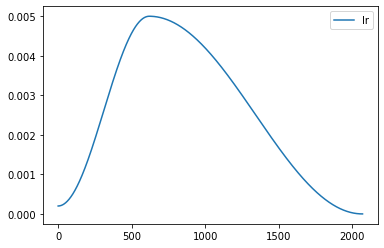

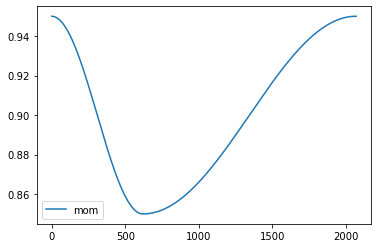

In [ ]:
import matplotlib.pyplot as plt
rec.plot()

## Inference

### Factors and Bias

In [ ]:
user_factors = learn.model.user_factors.weight.detach()
user_bias = learn.model.user_bias.weight.detach().squeeze()
movie_factors = learn.model.movie_factors.weight.detach()
movie_bias = learn.model.movie_bias.weight.detach().squeeze()

### Movies with lowest bias

[Kaggle: Collaborative Filtering Deep Dive](https://www.kaggle.com/code/jhoward/collaborative-filtering-deep-dive#Interpreting-Embeddings-and-Biases).  

This means that even when user factors match with the factors of these movies, they still tend to receive a small rating:

In [ ]:
lowest_movie_b = torch.argsort(movie_bias, descending=False)[:5]
[midx2title[idx.item()] for idx in lowest_movie_b]

['Cable Guy, The (1996)',
 'Children of the Corn: The Gathering (1996)',
 'Crow: City of Angels, The (1996)',
 'Robocop 3 (1993)',
 'Jury Duty (1995)']

### Movies with largest bias

In [ ]:
largest_movie_b = torch.argsort(movie_bias, descending=True)[:5]
[midx2title[idx.item()] for idx in largest_movie_b]

['Titanic (1997)',
 'L.A. Confidential (1997)',
 'Apt Pupil (1998)',
 'As Good As It Gets (1997)',
 'Good Will Hunting (1997)']

In [ ]:
learn._fit??

## Movielens 1M

In [ ]:
movielens_1M_url = 'http://files.grouplens.org/datasets/movielens/ml-1m.zip'

filename = Path(movielens_1M_url).name
zip_path = Path('.')
extract_path = zip_path / Path(filename).stem

In [ ]:
extract_path

Path('ml-1m')

In [ ]:
Path(filename).exists(), extract_path.exists()

(False, False)

In [ ]:
if not Path(filename).exists():
    with urllib.request.urlopen(movielens_1M_url) as response:
        with open(filename, "wb") as f:
          f.write(response.read())

if not extract_path.exists():
    with zipfile.ZipFile(filename, "r") as zip_ref:
        zip_ref.extractall(zip_path)

In [ ]:
ratings_1m = pd.read_csv(extract_path/'ratings.dat', delimiter='::', header=None, engine='python',
                        names=['user_id','item_id','rating','timestamp'])
ratings_1m = ratings_1m[['user_id','item_id','rating']].copy()
ratings_1m

,user_id,item_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
...,...,...,...
1000204,6040,1091,1
1000205,6040,1094,5
1000206,6040,562,5
1000207,6040,1096,4


In [ ]:
len(ratings_1m.item_id.unique()), len(ratings_1m.user_id.unique())

(3706, 6040)

In [ ]:
# https://stackoverflow.com/a/33819765

movies_1m = pd.read_csv(
    extract_path/'movies.dat', delimiter='::', encoding='ISO-8859-1', # encoding='latin-1',
    usecols=(0,1), header=None, engine='python', names=('item_id','title')
)
movies_1m.head()

,item_id,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [ ]:
ratings_1m = ratings_1m.merge(movies_1m)
ratings_1m.head()

,user_id,item_id,rating,title
0,1,1193,5,One Flew Over the Cuckoo's Nest (1975)
1,2,1193,5,One Flew Over the Cuckoo's Nest (1975)
2,12,1193,4,One Flew Over the Cuckoo's Nest (1975)
3,15,1193,4,One Flew Over the Cuckoo's Nest (1975)
4,17,1193,5,One Flew Over the Cuckoo's Nest (1975)


## Splits

### Split 1

In [ ]:
splits = split_dataframe_by_group(
    ratings_1m, ratio=0.8,
    filter_by="item", seed=104577657,
    col_user='user_id', col_item='title'
)

In [ ]:
train_df = ratings_1m.iloc[splits[0]]
valid_df = ratings_1m.iloc[splits[1]]

In [ ]:
# number of ratings by title
ratings_1m['nr_title'] = ratings_1m.groupby('title')['title'].transform('count')
ratings_1m['nr_user'] = ratings_1m.groupby('user_id')['user_id'].transform('count')
print(f'Number of titles with one review: {sum(ratings_1m.nr_title==1)}')

print(f'Number of users in train: {len(train_df.user_id.unique())}')
print(f'Number of movies in train: {len(train_df.title.unique())}')

print(f'Number of users in valid: {len(valid_df.user_id.unique())}')
print(f'Number of movies in valid: {len(valid_df.title.unique())}')

Number of titles with one review: 114
Number of users in train: 6040
Number of movies in train: 3706
Number of users in valid: 6037
Number of movies in valid: 3592


In [ ]:
users_not_in_valid = list(set(train_df.user_id) - set(valid_df.user_id))
users_not_in_valid

[160, 298, 2490]

### Split 2

In [ ]:
resplit = split_dataframe_by_group(
    ratings_1m[ratings_1m.user_id.isin(users_not_in_valid)], 
    ratio=0.8,
    filter_by="user", seed=104577657,
    col_user='user_id', col_item='title',
    sort_column='nr_title'
)

In [ ]:
final_splits = [splits[0] + resplit[0], splits[1] + resplit[1]]

In [ ]:
train_df = ratings_1m.iloc[final_splits[0]]
valid_df = ratings_1m.iloc[final_splits[1]]

In [ ]:
# number of ratings by title
print(f'Number of titles with one review: {sum(ratings_1m.nr_title==1)}')

print(f'Number of users in train: {len(train_df.user_id.unique())}')
print(f'Number of movies in train: {len(train_df.title.unique())}')

print(f'Number of users in valid: {len(valid_df.user_id.unique())}')
print(f'Number of movies in valid: {len(valid_df.title.unique())}')

Number of titles with one review: 114
Number of users in train: 6040
Number of movies in train: 3706
Number of users in valid: 6040
Number of movies in valid: 3592


In [ ]:
len(train_df), len(valid_df)

(798812, 201466)

In [ ]:
DEFAULT_USER_COL = 'user_id'
DEFAULT_ITEM_COL = 'title'

users = sorted(list(ratings_1m[DEFAULT_USER_COL].unique()))
titles = sorted(list(ratings_1m[DEFAULT_ITEM_COL].unique()))

uidx2user = {k:v for k,v in enumerate(users)}
user2uidx = {k:v for v,k in uidx2user.items()}

midx2title = {k:v for k,v in enumerate(titles)}
title2midx = {k:v for v,k in midx2title.items()}

In [ ]:
train_dataset = CollabDataset(train_df, user_col='user_id')

valid_dataset = CollabDataset(valid_df, user_col='user_id')

In [ ]:
bs = 64 * 3

t_sampler = BatchSampler(
    RandomSampler(train_dataset),
    batch_size=bs,
    drop_last=False)

v_sampler = BatchSampler(
    RandomSampler(valid_dataset),
    batch_size=bs,
    drop_last=False)

In [ ]:
t_dataloader = DataLoader(
    train_dataset, sampler=t_sampler, batch_size=None, num_workers=6)

v_dataloader = DataLoader(
    valid_dataset, sampler=v_sampler, batch_size=None, num_workers=6)

In [ ]:
%%time
for _ in t_dataloader: pass

CPU times: user 16.1 s, sys: 10.9 s, total: 27 s
Wall time: 6min 50s


In [ ]:
t_s = BatchSampler(RandomSampler(train_dataset), batch_size=bs, drop_last=False)

In [ ]:
%%time
for indices in t_s:
    users = ratings_1m.loc[indices]['user_id'].map(user2uidx)
    items = ratings_1m.loc[indices]['title'].map(title2midx)
    sample_df = pd.DataFrame(zip(users, items))
    torch.tensor(sample_df.values)
    targets = ratings_1m.loc[indices]['rating'].values
    torch.tensor(targets, dtype=torch.float)

CPU times: user 1min 10s, sys: 0 ns, total: 1min 10s
Wall time: 1min 9s


In [ ]:
users = ratings_1m['user_id'].map(user2uidx)

In [ ]:
class CustomDataLoader():
    def __init__(self, dataset, sampler):
        self.dataset = dataset
        self.sampler = sampler
    
    def __iter__(self):
        for indices in self.sampler:
            yield(self.dataset[indices])

In [ ]:
t_custom_dl = CustomDataLoader(train_dataset, t_sampler)

In [ ]:
%%time
for _ in t_custom_dl: pass

CPU times: user 30min 47s, sys: 0 ns, total: 30min 47s
Wall time: 30min 44s


In [ ]:
t_custom_dl

<__main__.CustomDataLoader>

In [ ]:
%%time
for _ in t_s: pass

CPU times: user 1.96 s, sys: 0 ns, total: 1.96 s
Wall time: 546 ms


In [ ]:
%%time
i=0
for _ in t_custom_dl: 
    print(i)
    i+=1
    if i==10: break

0
1
2
3
4
5
6
7
8
9
CPU times: user 5.56 s, sys: 465 ms, total: 6.02 s
Wall time: 5.01 s
